In [2]:
import networkx as nx
import numpy as np
import torch
from datetime import datetime
import os
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from icecream import ic

ic.configureOutput("debug | -> ")

import pandas as pd
import torch_geometric.transforms as T

#from create_dataset import CreateDataset

from models import GNNModel

import sys
sys.path.append("../FastCover/")
from utils import *

In [102]:
PATH_SAVE_TRAINS = 'runs/Erdos_MDH/'
PATH_TO_TRAIN = "../BRKGA/instances/Erdos/train/"
PATH_TO_VALIDATION = "../BRKGA/instances/Erdos/validation/"
MDH = False


Features = None
if MDH:
    num_features = 1
else:
    num_features = 4 # Change if needed
    
num_classes  = 2

threshold = 0.5

optimizer_name = "Adam"
lr = 5e-4
epochs = 21

SEED = 13

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

layers = ["GCN", "GAT","GraphConv", "SAGE"]
#layers = ["SAGE"]

Models = [GNNModel(c_in = num_features, c_hidden = 100, c_out = 2, num_layers = 2, layer_name = layer_name, dp_rate=0.1) for 
         layer_name in layers]

In [103]:
Instances = [graph for graph in os.listdir(PATH_TO_TRAIN + 'txt')]

graphs = []
for er in Instances:
    graph = igraph.Graph.Read_Edgelist(PATH_TO_TRAIN+"txt/"+er, directed = False)
    graphs.append(graph.to_networkx())    

OptInstances = [graph for graph in os.listdir(PATH_TO_TRAIN+'optimal')]
Solutions = []
for er in OptInstances:
    opt = []
    with open(PATH_TO_TRAIN+'optimal/'+er) as f:
        for line in f.readlines():
            opt.append(int(line.replace("\n", "")))
    Solutions.append(opt)

In [104]:
Instances = [graph for graph in os.listdir(PATH_TO_VALIDATION + 'txt')]

graphs_val = []
for er in Instances:
    graph = igraph.Graph.Read_Edgelist(PATH_TO_VALIDATION+"txt/"+er, directed = False)
    graphs_val.append(graph.to_networkx())    

    
OptInstances = [graph for graph in os.listdir(PATH_TO_VALIDATION+'optimal')]
Solutions_val = []
for er in OptInstances:
    opt = []
    with open(PATH_TO_VALIDATION+'optimal/'+er) as f:
        for line in f.readlines():
            opt.append(int(line.replace("\n", "")))
    Solutions_val.append(opt)

In [105]:
if not MDH:
    graphFeatures = [feat for feat in os.listdir(PATH_TO_TRAIN+'feats')]
    Features = []
    for er in graphFeatures:
        temp = []
        with open(PATH_TO_TRAIN+'feats/'+er) as f:
            for line in f.readlines()[1:]:
                feats = np.array(line.split(","), dtype = float)
                temp.append(feats)
        Features.append(np.array(temp))
        
        
    graphFeatures_val = [feat for feat in os.listdir(PATH_TO_VALIDATION+'feats')]
    Features_val = []
    for er in graphFeatures_val:
        temp = []
        with open(PATH_TO_VALIDATION+'feats/'+er) as f:
            for line in f.readlines()[1:]:
                feats = np.array(line.split(","), dtype = float)
                temp.append(feats)
        Features_val.append(np.array(temp))

In [43]:
len(Features_val)

6

In [11]:
D = (Features[0] - np.min(Features[0], axis = 0)) / ( np.max(Features[0], axis = 0) - np.min(Features[0], axis = 0) )

In [14]:
np.min(D, axis = 0)

array([0., 0., 0., 0., 0.])

In [106]:
Graphs_Train = Convert2DataSet(graphs, Solutions, feats = Features)
Graphs_Val = Convert2DataSet(graphs_val, Solutions_val, feats = Features_val)
num_features = Graphs_Train[0].num_features
num_classes = Graphs_Train[0].num_classes

## Train

In [107]:
class EarlyStopping():
    def __init__(self, patience):
        self.minloss = np.inf
        self.dt_string = datetime.now().strftime("%m-%d_%H-%M")
        self.count = 0
        self.patience = patience
        self.epoch = 0
        self.history = []
        
    def check(self, model, Graphs_Val, Graphs_Train):
        self.epoch += 1
        
        val_loss = 0
        for data in Graphs_Val:
            val_loss += F.nll_loss(model(data.x, data.edge_index), data.y).detach().numpy() / len(Graphs_Val)
            
        if val_loss < self.minloss:
            print(f"\nval_loss improved from {self.minloss :.3f} to {val_loss:.3f} Saving...")
            torch.save(model.state_dict(), f=f"{PATH_SAVE_TRAINS}{layers[i]}_seed_{SEED}_thr_{int(threshold*10)}_date_{self.dt_string}.pt")
            self.minloss = val_loss
            self.count = 0
        else:
            print(f"\nEarlyStopping count {self.count} of {self.patience}\n")
            self.count += 1
        
        
        val_train = 0
        for data in Graphs_Train:
            val_train += F.nll_loss(model(data.x, data.edge_index), data.y).detach().numpy() / len(Graphs_Train)
            
        self.history.append([self.epoch, val_loss, val_train])
        
        if self.count >= self.patience:
            print("\nEarlyStopping limit reached.\n")
            return True
        else:
            return False
    
    def plot_history(self, title_ = ""):
        plt.plot(np.array(self.history).T[0], np.array(self.history).T[1], label = "Val loss")
        plt.plot(np.array(self.history).T[0], np.array(self.history).T[2], label = "Train loss")
        plt.title(f"Learning curve {title_}")
        plt.legend()
        plt.grid()
        plt.show()
    

In [108]:
def train(model, optimizer, data):
        optimizer.zero_grad()

        F.nll_loss(model(data.x, data.edge_index), data.y).backward()
        optimizer.step()
        return model, optimizer
      
    
@torch.no_grad()
def test(data, model):
  model.eval()
  logits = model(data.x, data.edge_index)
  pred = logits.max(1)[1]
  acc = pred.eq(data.y).sum().item() / data.num_nodes
  return acc




In [111]:
torch.manual_seed(SEED)

#for i in range(len(Models)):
for i in range(3, 4):
    print()
    print(f" ----- Model:{layers[i]} -----")
    optimizer = getattr(torch.optim, optimizer_name)(Models[i].parameters(), lr = lr)
    
    ES = EarlyStopping(patience = 12)
    
    for epoch in range(1, 61):
        
        for data in Graphs_Train:
            train(Models[i], optimizer, data)
        
        if epoch%5 == 0:
            #torch.save(Models[i].state_dict(), f=f"{PATH_SAVE_TRAINS_CHECKPOINTS}Checkpoint-model-{layers[i]}-epoch-{epoch}.pt")
            print(f"Epoch {epoch} saved for {layers[i]}.\n")
        
            Acc = []

            for data in Graphs_Train:
                Acc.append(test(data, Models[i]))
            print(f"Mean Acc: {np.mean(Acc)}")
            print()
        
        
        if ES.check(Models[i], Graphs_Val, Graphs_Train):
            break
    #torch.save(Models[i].state_dict(), f=f"{PATH_SAVE_TRAINS}{layers[i]}_seed_{SEED}_thr_{int(threshold*10)}_date_{dt_string}.pt")
    
    print(f"{layers[i]} saved in {PATH_SAVE_TRAINS}\n")
    ES.plot_history(layers[i])


 ----- Model:SAGE -----

val_loss improved from inf to 0.504 Saving...

val_loss improved from 0.504 to 0.488 Saving...

val_loss improved from 0.488 to 0.464 Saving...

val_loss improved from 0.464 to 0.432 Saving...
Epoch 5 saved for SAGE.

Mean Acc: 0.818696875


val_loss improved from 0.432 to 0.398 Saving...

val_loss improved from 0.398 to 0.369 Saving...

val_loss improved from 0.369 to 0.343 Saving...

val_loss improved from 0.343 to 0.319 Saving...

val_loss improved from 0.319 to 0.299 Saving...
Epoch 10 saved for SAGE.

Mean Acc: 0.8995875


val_loss improved from 0.299 to 0.282 Saving...

val_loss improved from 0.282 to 0.267 Saving...

val_loss improved from 0.267 to 0.255 Saving...

val_loss improved from 0.255 to 0.245 Saving...

val_loss improved from 0.245 to 0.236 Saving...
Epoch 15 saved for SAGE.

Mean Acc: 0.926921875


val_loss improved from 0.236 to 0.228 Saving...

val_loss improved from 0.228 to 0.222 Saving...

val_loss improved from 0.222 to 0.216 Saving...


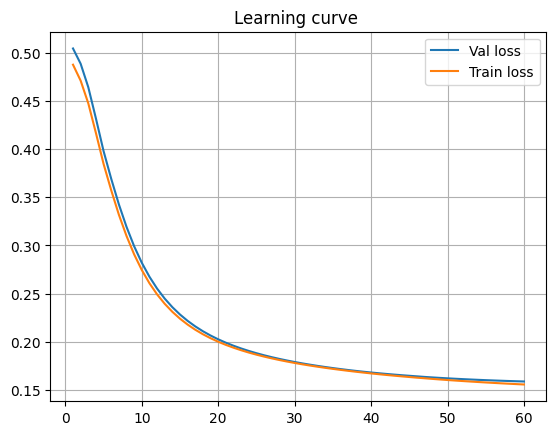

In [112]:
ES.plot_history()
#for sage

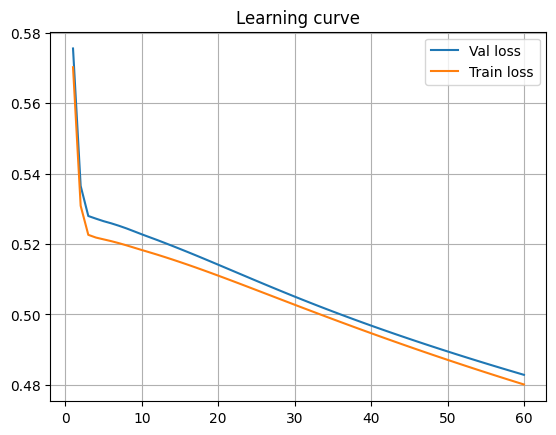

In [95]:
#ES.plot_history()
#for GCN

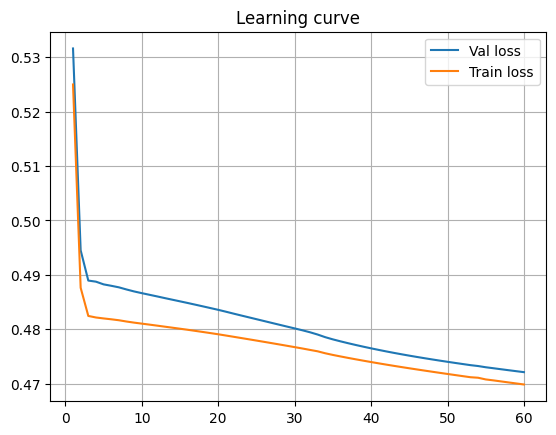

In [98]:
ES.plot_history()

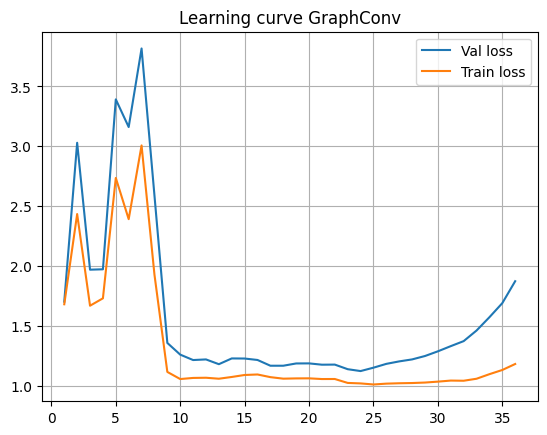

In [110]:
ES.plot_history("GraphConv")

In [10]:
%pwd

'C:\\Users\\Jairo Enrique\\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\\UAB\\IIIA\\GNN-BRKGA\\Models'

In [11]:
name = "SAGE_mut_0.1_cross_0.6_type_uniform_iter_2"

if not os.path.exists(name):
    os.mkdir(name)
    


In [30]:
import os
d = os.listdir("./runs/eliminar")
d

['GCN_2_mut_0.1_cross_0.6_type_one_point_iter_3',
 'GCN_3_mut_0.1_cross_0.6_type_one_point_iter_3',
 'SAGE_1_mut_0.1_cross_0.6_type_one_point_iter_3',
 'SAGE_2_mut_0.1_cross_0.6_type_one_point_iter_3',
 'SAGE_3_mut_0.1_cross_0.6_type_one_point_iter_3']

In [35]:
f ="./runs/eliminar/"+d[4]+"/"
with open(f'{f}SAGE_iter_1.npy', 'rb') as f:
    a = np.load(f, allow_pickle = True)
    
a, len(a)

(array([-8.47486689,  5.6921779 ,  1.52711059,  6.91269772,  9.33249705,
        -3.9491625 , -3.47851705,  4.29748694,  4.69300465, -8.42879934,
        -7.93319268,  7.28797738,  7.51141674,  0.66667338, -3.20569348,
        -9.0565023 , -8.31714373, -0.97849094,  0.32527263, -1.99087185,
        -4.16313873,  5.72377743,  6.93897276,  5.10324972,  7.12146573,
         1.7532162 , -5.34428925, -3.98711062,  6.01228096,  0.6243755 ,
        -8.7505699 , -9.44079635,  6.49540221,  3.3076658 , -6.91576495,
        -7.90962891,  2.93329363,  1.86988551,  5.37379304, -7.29669202,
        -2.2094033 , -4.3084466 ,  1.74394816, -1.48407632, -6.02601239,
         6.71921322,  4.00566146,  7.2200687 ,  4.06167025, -5.38340287,
        -2.42981564,  7.34502628, -7.94427077, -9.16267109, -6.16295239,
        -8.97583314,  5.10532425, -4.71714407, -7.65408508,  4.14980778,
         0.54893249,  8.59517303, -8.7881952 , -0.48055179,  6.22609552,
         8.67518163, -2.11848064, -5.35289706,  5.8

In [28]:
d = [k for k in range(10)]
d += [k for k in range(10,20)]
d

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [29]:
cant_layers = [1]*5
cant_layers += [2]*5
cant_layers += [3]*5
cant_layers

[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]

In [13]:
import subprocess
import os

In [69]:
os.chdir('../')

In [63]:
os.chdir('./Models/')

In [15]:
%pwd

'C:\\Users\\Jairo Enrique\\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\\UAB\\IIIA\\GNN-BRKGA\\BRKGA'

In [29]:
## Shell=False helps the process terminate
process = subprocess.Popen(["./Ejemplo.exe", "hola"])

## Get exit codes
out, err = process.communicate()
errcode = process.returncode
print(out)

process.kill() 
process.terminate()

None


In [60]:
path_save = "../Models/results/scalefree_MDH_socialnetworks/Pruebas_GA/TwoLayers/Results_SMS3.txt"

path_prob = "../Models/probabilidades/scalefree_socialnetworks/Pruebas_GA/TwoLayers/";

model = "SAGE30"

In [61]:
os.chdir('../BRKGA/')
res = subprocess.run(["./diffusion.exe", "-pp", path_prob, "-ps", path_save, "-m", model])
if res.returncode == 1:
    print("No se logró")


In [90]:
res = subprocess.run([
sys.executable, "ExtractProbabilitiesModels.py", "-pm", "runs/Erdos/Pruebas_GA/Allfeatures/", "-pi",
    "../BRKGA/instances/socialnetworks/", "-ps", "runs/eliminar/"])

if res.returncode == 1:
    print("No se logró")

No se logró


In [82]:
os.chdir('./Models')

In [89]:
%pwd

'C:\\Users\\Jairo Enrique\\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\\UAB\\IIIA\\GNN-BRKGA\\Models'

In [83]:
python ExtractProbabilitiesModels.py -pm "runs/Erdos/Pruebas_GA/Allfeatures/" -pi "../BRKGA/instances/socialnetworks/" -ps "runs/eliminar/"

'C:\\Users\\Jairo Enrique\\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\\UAB\\IIIA\\GNN-BRKGA\\Models'

In [10]:
GNN(num_node_features = 5, num_classes = 2, name_layer = "SAGE", num_layers = cant_layers)

GNN()

In [18]:
import igraph
import dgl
import torch
import time
import os
import networkx as nx
from datetime import datetime
import pandas as pd
import sys
sys.path.append("../FastCover/")
from utils import *
import warnings
warnings.filterwarnings('ignore')
import argparse
from models import GNN


#v.g. python ExtractProbabilitiesModels.py -pm "runs/Erdos/" -pi "../BRKGA/instances/Erdos/test/" -ps "./probabilidades/Erdos_Erdos/"

PATH_TO_TEST = "../BRKGA/instances/socialnetworks/"

MDH = False

PATH_SAVE_RESULTS = "runs/eliminar/SAGE_3_mut_0.1_cross_0.6_type_one_point_iter_3/probs/"

PATH_SAVED_TRAINS = "runs/eliminar/SAGE_3_mut_0.1_cross_0.6_type_one_point_iter_3/"


#PATH_TO_TEST = "../BRKGA/instances/txt/"
#PATH_SAVED_TRAINS = "runs/scalefree/"
#PATH_SAVE_RESULTS = 'probabilidades/scalefree/'

Graphs = [graph for graph in os.listdir(PATH_TO_TEST + "txt") if ".txt" in graph]

NAME_SAVE_RESULTS = 'Models' #Change this

Features = [None]*len(Graphs)

if MDH:
    num_features = 1
else:
    num_features = 5 # Change if needed

    #graphFeatures = [feat for feat in os.listdir(PATH_TO_TEST+'feats') if ".txt" in feat]
    Features = []
    for er in Graphs:
        temp = []
        #with open(PATH_TO_TEST+'feats/'+er) as f:
        with open(PATH_TO_TEST+'feats/'+er.replace(".txt", "_feat.txt")) as f:
            for line in f.readlines()[1:]:
                feats = np.array(line.split(","), dtype = float)
                temp.append(feats)
        
        temp = np.array(temp)
        #temp = np.delete(temp, 0, 1)
        Features.append(temp)

        



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

use_cuda = False

dt_string = datetime.now().strftime("%m-%d_%H-%M")

RUNS_LIST = [run for run in os.listdir(PATH_SAVED_TRAINS) if ".pt" in run]

SEEDS = []
MODELS = []
for run_name in RUNS_LIST:
    SEEDS.append(run_name.split("_")[3])
    MODELS.append(run_name.split("_")[0])
    #EPOCHS.append(run_name.split("_")[2])
    
records = []
Total = len(Graphs)

def save(name, model, out):
    with open(f'{PATH_SAVE_RESULTS}{model}_{name}', 'w') as f:
        out = out.detach().numpy()
        e = 0.0001
        for o in out:
            f.write(str(np.round(o + e, 6)))
            f.write("\n")



In [27]:
for run_name, model, seed in zip(RUNS_LIST, MODELS, SEEDS):
    print()
    print(f"Evaluation of model: {model}, seed: {seed} in {run_name}")
    print()
    
    #net = GNN(c_in = num_features, c_hidden = 100, c_out = 2, num_layers = 2, layer_name = model, dp_rate=0.1)
    cant_layers = 1 if model[4:] == '' else int(model[4:])
    net = GNN(num_node_features = 5, num_classes = 2, name_layer = model[:4], num_layers = cant_layers)
    
    net.load_state_dict(torch.load(PATH_SAVED_TRAINS+run_name))
    
    if use_cuda:
        net.cuda()

    c = 1
    for file, feat in zip(Graphs, Features):
            print(f"Loading {PATH_TO_TEST}txt/{file} ...")
            name = file.split(".")[0].replace("graph_", "")

            graph = igraph.Graph.Read_Edgelist(PATH_TO_TEST +"txt/"+ file, directed = False).to_networkx()
            data = Convert2DataSet([graph], [[]], [feat])[0]
            

            #G = graph.to_networkx().to_undirected()

            n = len(graph.nodes())
            
            start_time = time.time()

            # Puesto viene de un log softmax y queremos extraer las probs de que pertenezcan 
            # a la solución, lo cual está en la columna 1
            out = torch.exp(net(data)).T[1]
            
            save(file, model, out)
         
           
            c+=1
print(f"Evaluation has finnished successfully. \nData saved in {PATH_SAVE_RESULTS}")




Evaluation of model: SAGE3, seed: thr in SAGE3_seed_13_thr_5_date_02-14_17-27.pt

Loading ../BRKGA/instances/socialnetworks/txt/Amazon0302.txt ...


KeyboardInterrupt: 

In [2]:
import subprocess

In [8]:
path_save = "runs/eliminar/SAGE_3_mut_0.1_cross_0.6_type_one_point_iter_3/"

path_prob = "runs/eliminar/SAGE_3_mut_0.1_cross_0.6_type_one_point_iter_3/probs/";

model = "SAGE3"

res = subprocess.run(["./diffusion.exe", "-pp", path_prob, "-ps", path_save, "-m", model])
if res.returncode == 1:
    print("No se logró")
elif res.returncode == 0:
    print("Se logró")

Se logró


In [4]:
f"./diffusion.exe -pp {path_prob} -ps {path_save} -m {model}"


'./diffusion.exe -pp /runs/eliminar/SAGE_3_mut_0.1_cross_0.6_type_one_point_iter_3/probs/ -ps /runs/eliminar/SAGE_3_mut_0.1_cross_0.6_type_one_point_iter_3/Results.txt -m SAGE'

In [10]:
"hola"[:-1]

'hol'